In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ezc3d import c3d

import matplotlib
%matplotlib qt


In [45]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

In [48]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(projection='3d')

path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

for subject in tqdm(subjects):
    #     print(subject)
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        if "C4" not in filename:
            continue

        try:
            path = os.path.join(path, subject, filename)
            content = c3d(
                os.path.join(path, subject, filename), extract_forceplat_data=True
            )

            # ... Trajectroies
            trajectory_x_r = content['data']['points'][1, 9:15, :]
            trajectory_y_r = content['data']['points'][0, 9:15, :]
            trajectory_z_r = content['data']['points'][2, 9:15, :]

            trajectory_x_l = content['data']['points'][1, 20:26, :]
            trajectory_y_l = content['data']['points'][0, 20:26, :]
            trajectory_z_l = content['data']['points'][2, 20:26, :]

            # ... Forces
            force_x_r = content['data']['platform'][0]['force'][1, :]
            force_y_r = content['data']['platform'][0]['force'][0, :]
            force_z_r = content['data']['platform'][0]['force'][2, :]

            force_x_l = content['data']['platform'][0]['force'][1, :]
            force_y_l = content['data']['platform'][0]['force'][0, :]
            force_z_l = content['data']['platform'][0]['force'][2, :]

            # ... Moments
            moment_x_r = content['data']['platform'][0]['moment'][1, :]
            moment_y_r = content['data']['platform'][0]['moment'][0, :]
            moment_z_r = content['data']['platform'][0]['moment'][2, :]

            moment_x_l = content['data']['platform'][0]['moment'][1, :]
            moment_y_l = content['data']['platform'][0]['moment'][0, :]
            moment_z_l = content['data']['platform'][0]['moment'][2, :]

            for i in range(5):
                ax.plot3D(trajectory_y_r[i, :],
                        trajectory_x_r[i, :], trajectory_z_r[i, :])

            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
        except:
            pass


  2%|▏         | 1/50 [00:00<00:00, 2392.64it/s]


NotADirectoryError: [Errno 20] Not a directory: '../../Dataset/gait-dbase-1/2015027/2015027_C4_04.c3d/2015027/2015027_C4_03.c3d/2015027/2015027_C4_01.c3d/2015027/2015027_C4_02.c3d/2015030'

In [47]:
path

'../../Dataset/gait-dbase-1/2015027/2015027_C4_04.c3d'

In [38]:
trajectory_x_r.shape

(6, 188)

In [39]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(projection='3d')

for i in range(5):
    ax.plot3D(trajectory_y_r[i, :], trajectory_x_r[i, :], trajectory_z_r[i, :])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [40]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(projection='3d')


ax.plot3D(force_x_r, force_y_r, force_z_r)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [6]:
force_x_r.shape

(2820,)

In [7]:
import os
import gc
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter, medfilt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style("white", {'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set_palette("Set2")
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [8]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

In [9]:
class LowPassFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=1500, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y

In [10]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def get_processed_grf(grf, clip=False):
    singn_corrected = grf # if np.mean(grf) > 20 else (-grf)
    processed_grf = LowPassFilter.apply(singn_corrected, fs=1500, cutoff=20)
    processed_grf = processed_grf - np.median(processed_grf)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 3, axis=0).T

def get_processed_moment(moment):
    processed_moment = LowPassFilter.apply(moment, fs=1500, cutoff=20)
    return resample(processed_moment, N_SAMPLES * 3, axis=0).T

def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 9:15, :]
        trajectory_y = content['data']['points'][1, 9:15, :]
        trajectory_z = content['data']['points'][2, 9:15, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 20:26, :]
        trajectory_y = content['data']['points'][1, 20:26, :]
        trajectory_z = content['data']['points'][2, 20:26, :]

    else:
        raise ValueError('Third foot is not allowed')

    # trajectory_x = LowPassFilter.apply(trajectory_x, fs=200, cutoff=20)
    # trajectory_y = LowPassFilter.apply(trajectory_y, fs=200, cutoff=20)
    # trajectory_z = LowPassFilter.apply(trajectory_z, fs=200, cutoff=20)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 3, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 3, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 3, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force(content):
    force_x = []
    force_y = []
    force_z = []
    for i in range(2):
        force_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_x, force_y, force_z

def get_moment(content):
    moment_x = []
    moment_y = []
    moment_z = []
    for i in range(2):
        moment_x.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][0, :]
            )
        )
        moment_y.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][1, :]
            )
        )
        moment_z.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][2, :]
            )
        )

    return moment_x, moment_y, moment_z

In [33]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

# subjects = subjects[:18]

for subject in tqdm(subjects):
    #     print(subject)
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        if "ST" in filename:
            continue

        if "C4" not in filename:
            continue

        # print(subject, filename, end=' ')

        try:
            content = c3d(
                os.path.join(path, subject, filename), extract_forceplat_data=True
            )

            # print('loaded', end=' ')

            trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(
                content, "right"
            )
            trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(
                content, "left"
            )

            force_x, force_y, force_z = get_force(content)
            moment_x, moment_y, moment_z = get_moment(content)

            del content
            gc.collect()

            # force_combined_z = force_z[0] + force_z[1]
            # force_mask = force_combined_z >= FORCE_THRESHOLD

            # # ... Remove all zero GRF samples
            # if (
            #     np.sum(force_z[0]) <= FORCE_THRESHOLD
            #     or np.sum(force_z[1]) <= FORCE_THRESHOLD
            # ):
            #     # print(os.path.join(path, subject, filename))
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # # ... Remove bad samples
            # if np.mean(force_mask) <= 0.5:
            #     # print(os.path.join(path, subject, filename))
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # # ... Remove samples that starts and ends abruptly
            # if (
            #     np.mean(force_combined_z[:10]) >= 200
            #     or np.mean(force_combined_z[-10:]) >= 200
            # ):
            #     # print(os.path.join(path, subject, filename))
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # mask_force_z_1 = force_z[0] > FORCE_THRESHOLD
            # mask_force_z_2 = force_z[1] > FORCE_THRESHOLD

            # start_1 = np.min(np.argwhere(mask_force_z_1 == True))
            # end_1 = np.max(np.argwhere(mask_force_z_1 == True))

            # if (end_1 - start_1) < 700 or (end_1 - start_1) > 1700:
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # start_2 = np.min(np.argwhere(mask_force_z_2 == True))
            # end_2 = np.max(np.argwhere(mask_force_z_2 == True))

            # if (end_2 - start_2) < 700 or (end_2 - start_2) > 1700:
            #     n_bad_samples = n_bad_samples + 1
            #     continue

            # # print('1', end=' ')

            # force_x_1 = force_x[0][start_1:end_1]
            # force_y_1 = force_y[0][start_1:end_1]
            # force_z_1 = force_z[0][start_1:end_1]

            # force_x_2 = force_x[1][start_2:end_2]
            # force_y_2 = force_y[1][start_2:end_2]
            # force_z_2 = force_z[1][start_2:end_2]

            # moment_x_1 = moment_x[0][start_1:end_1]
            # moment_y_1 = moment_y[0][start_1:end_1]
            # moment_z_1 = moment_z[0][start_1:end_1]

            # moment_x_2 = moment_x[1][start_2:end_2]
            # moment_y_2 = moment_y[1][start_2:end_2]
            # moment_z_2 = moment_z[1][start_2:end_2]

            # temp_l = trajectory_z_l[start_1:end_1, 0]
            # temp_r = trajectory_z_r[start_1:end_1, 0]

            # force_x_r = 0
            # force_y_r = 0
            # force_z_r = 0

            # force_x_l = 0
            # force_y_l = 0
            # force_z_l = 0

            # moment_x_r = 0
            # moment_y_r = 0
            # moment_z_r = 0

            # moment_x_l = 0
            # moment_y_l = 0
            # moment_z_l = 0

            # if np.sum(temp_l) > np.sum(temp_r):
            #     force_x_r = force_x_1
            #     force_y_r = force_y_1
            #     force_z_r = force_z_1

            #     force_x_l = force_x_2
            #     force_y_l = force_y_2
            #     force_z_l = force_z_2

            #     moment_x_r = moment_x_1
            #     moment_y_r = moment_y_1
            #     moment_z_r = moment_z_1

            #     moment_x_l = moment_x_2
            #     moment_y_l = moment_y_2
            #     moment_z_l = moment_z_2

            #     trajectory_x_r = trajectory_x_l[start_2:end_2]
            #     trajectory_y_r = trajectory_y_r[start_2:end_2]
            #     trajectory_z_r = trajectory_z_r[start_2:end_2]

            #     trajectory_x_l = trajectory_x_r[start_1:end_1]
            #     trajectory_y_l = trajectory_y_l[start_1:end_1]
            #     trajectory_z_l = trajectory_z_l[start_1:end_1]

            # else:
            #     force_x_l = force_x_1
            #     force_y_l = force_y_1
            #     force_z_l = force_z_1

            #     force_x_r = force_x_2
            #     force_y_r = force_y_2
            #     force_z_r = force_z_2

            #     moment_x_l = moment_x_1
            #     moment_y_l = moment_y_1
            #     moment_z_l = moment_z_1

            #     moment_x_r = moment_x_2
            #     moment_y_r = moment_y_2
            #     moment_z_r = moment_z_2

            #     trajectory_x_r = trajectory_x_l[start_1:end_1]
            #     trajectory_y_r = trajectory_y_r[start_1:end_1]
            #     trajectory_z_r = trajectory_z_r[start_1:end_1]

            #     trajectory_x_l = trajectory_x_r[start_2:end_2]
            #     trajectory_y_l = trajectory_y_l[start_2:end_2]
            #     trajectory_z_l = trajectory_z_l[start_2:end_2]

            # # print('2', end=' ')

            # # ... Resample
            # trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
            # trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
            # trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

            # trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
            # trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
            # trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

            # force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
            # force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
            # force_z_r = resample(force_z_r, N_SAMPLES, axis=0)

            # force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
            # force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
            # force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

            # moment_x_r = resample(moment_x_r, N_SAMPLES, axis=0)
            # moment_y_r = resample(moment_y_r, N_SAMPLES, axis=0)
            # moment_z_r = resample(moment_z_r, N_SAMPLES, axis=0)

            # moment_x_l = resample(moment_x_l, N_SAMPLES, axis=0)
            # moment_y_l = resample(moment_y_l, N_SAMPLES, axis=0)
            # moment_z_l = resample(moment_z_l, N_SAMPLES, axis=0)

            # # print('3', end=' ')

            # # ... sign correction
            # if np.mean(force_y_r[: int(N_SAMPLES / 2)]) > 0:
            #     force_y_r = -force_y_r
            # if np.mean(force_y_l[: int(N_SAMPLES / 2)]) > 0:
            #     force_y_l = -force_y_l

            # if np.mean(force_x_r) < 0:
            #     force_x_r = -force_x_r
            # if np.mean(force_x_l) < 0:
            #     force_x_l = -force_x_l

            # if np.mean(moment_x_r) < 0:
            #     moment_x_r = -moment_x_r
            # if np.mean(moment_x_l) < 0:
            #     moment_x_l = -moment_x_l

            # if np.mean(moment_y_r[: int(N_SAMPLES / 2)]) > 0:
            #     moment_y_r = -moment_y_r
            # if np.mean(moment_y_l[: int(N_SAMPLES / 2)]) > 0:
            #     moment_y_l = -moment_y_l

            # if np.mean(moment_z_r[: int(N_SAMPLES / 2)]) > 0:
            #     moment_z_r = -moment_z_r
            # if np.mean(moment_z_l[: int(N_SAMPLES / 2)]) > 0:
            #     moment_z_l = -moment_z_l

            # # if np.mean(moment_y_r) < 0:
            # #     moment_y_r = -moment_y_r
            # # if np.mean(moment_y_l) < 0:
            # #     moment_y_l = -moment_y_l

            # # if np.mean(moment_z_r) < 0:
            # #     moment_z_r = -moment_z_r
            # # if np.mean(moment_z_l) < 0:
            # #     moment_z_l = -moment_z_l

            # # ... Standardize
            # trajectory_x_r = standardize(trajectory_x_r)
            # trajectory_y_r = standardize(trajectory_y_r)
            # trajectory_z_r = standardize(trajectory_z_r)

            # trajectory_x_l = standardize(trajectory_x_l)
            # trajectory_y_l = standardize(trajectory_y_l)
            # trajectory_z_l = standardize(trajectory_z_l)

            # force_x_r = standardize(force_x_r)
            # force_y_r = standardize(force_y_r)
            # force_z_r = standardize(force_z_r)

            # force_x_l = standardize(force_x_l)
            # force_y_l = standardize(force_y_l)
            # force_z_l = standardize(force_z_l)

            # moment_x_r = standardize(moment_x_r)
            # moment_y_r = standardize(moment_y_r)
            # moment_z_r = standardize(moment_z_r)

            # moment_x_l = standardize(moment_x_l)
            # moment_y_l = standardize(moment_y_l)
            # moment_z_l = standardize(moment_z_l)

            # print('4', end=' ')

            _features_l = pd.DataFrame(
                np.concatenate(
                    [trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1
                ),
                columns=[
                    "fal_x",
                    "tam_x",
                    "fcc_x",
                    "fm1_x",
                    "fm2_x",
                    "fm5_x",
                    "fal_y",
                    "tam_y",
                    "fcc_y",
                    "fm1_y",
                    "fm2_y",
                    "fm5_y",
                    "fal_z",
                    "tam_z",
                    "fcc_z",
                    "fm1_z",
                    "fm2_z",
                    "fm5_z",
                ],
            )

            _features_r = pd.DataFrame(
                np.concatenate(
                    [trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1
                ),
                columns=[
                    "fal_x",
                    "tam_x",
                    "fcc_x",
                    "fm1_x",
                    "fm2_x",
                    "fm5_x",
                    "fal_y",
                    "tam_y",
                    "fcc_y",
                    "fm1_y",
                    "fm2_y",
                    "fm5_y",
                    "fal_z",
                    "tam_z",
                    "fcc_z",
                    "fm1_z",
                    "fm2_z",
                    "fm5_z",
                ],
            )

            _features = pd.concat([_features_l, _features_r], axis=0)

            _target_r = pd.DataFrame(
                np.stack(
                    [
                        force_x_r,
                        force_y_r,
                        force_z_r,
                        moment_x_r,
                        moment_y_r,
                        moment_z_r,
                    ],
                    axis=1,
                ),
                columns=["fx", "fy", "fz", "mx", "my", "mz"],
            )

            _target_l = pd.DataFrame(
                np.stack(
                    [
                        force_x_l,
                        force_y_l,
                        force_z_l,
                        moment_x_l,
                        moment_y_l,
                        moment_z_l,
                    ],
                    axis=1,
                ),
                columns=["fx", "fy", "fz", "mx", "my", "mz"],
            )

            _target = pd.concat([_target_r, _target_l], axis=0)

            features = pd.concat([features, _features], axis=0, ignore_index=True)
            target = pd.concat([target, _target], axis=0, ignore_index=True)

            # print('5')

            records.append(filename)

            n_samples = n_samples + 1

        except Exception as e:
            print(f"ERROR [{subject}/{filename}]: {e}")
            n_bad_samples = n_bad_samples + 1
            pass

print("Number of good samples: ", n_samples)
print("Number of bad samples: ", n_bad_samples)


  0%|          | 0/18 [00:00<?, ?it/s]

ERROR [2015027/2015027_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015027/2015027_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1


  6%|▌         | 1/18 [00:00<00:09,  1.75it/s]

ERROR [2015027/2015027_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015027/2015027_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015030/2015030_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015030/2015030_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015030/2015030_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015030/2015030_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1


 11%|█         | 2/18 [00:01<00:10,  1.54it/s]

ERROR [2015030/2015030_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014025/2014025_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014025/2014025_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014025/2014025_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1


 17%|█▋        | 3/18 [00:01<00:09,  1.62it/s]

ERROR [2014025/2014025_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014003/2014003_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1


 22%|██▏       | 4/18 [00:02<00:07,  1.88it/s]

ERROR [2014003/2014003_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014003/2014003_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015015/2015015_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015015/2015015_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015015/2015015_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015015/2015015_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1


 28%|██▊       | 5/18 [00:02<00:07,  1.75it/s]

ERROR [2015015/2015015_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014006/2014006_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014006/2014006_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014006/2014006_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1


 33%|███▎      | 6/18 [00:03<00:06,  1.75it/s]

ERROR [2014006/2014006_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015032/2015032_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1


 39%|███▉      | 7/18 [00:03<00:05,  1.93it/s]

ERROR [2015032/2015032_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015032/2015032_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015005/2015005_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015005/2015005_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015005/2015005_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015005/2015005_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1


 44%|████▍     | 8/18 [00:04<00:05,  1.69it/s]

ERROR [2015005/2015005_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014024/2014024_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014024/2014024_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014024/2014024_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1


 50%|█████     | 9/18 [00:05<00:05,  1.63it/s]

ERROR [2014024/2014024_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014024/2014024_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014046/2014046_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014046/2014046_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014046/2014046_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014046/2014046_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1


 56%|█████▌    | 10/18 [00:05<00:04,  1.61it/s]

ERROR [2014046/2014046_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014011/2014011_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014011/2014011_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014011/2014011_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1


 61%|██████    | 11/18 [00:06<00:04,  1.66it/s]

ERROR [2014011/2014011_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014052/2014052_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014052/2014052_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014052/2014052_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1


 67%|██████▋   | 12/18 [00:07<00:03,  1.71it/s]

ERROR [2014052/2014052_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014030/2014030_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014030/2014030_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014030/2014030_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1


 72%|███████▏  | 13/18 [00:07<00:03,  1.55it/s]

ERROR [2014030/2014030_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014030/2014030_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014033/2014033_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014033/2014033_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014033/2014033_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014033/2014033_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1


 78%|███████▊  | 14/18 [00:08<00:02,  1.46it/s]

ERROR [2014033/2014033_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014053/2014053_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014053/2014053_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014053/2014053_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1


 83%|████████▎ | 15/18 [00:09<00:02,  1.41it/s]

ERROR [2014053/2014053_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014053/2014053_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014049/2014049_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014049/2014049_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014049/2014049_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014049/2014049_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1


 89%|████████▉ | 16/18 [00:10<00:01,  1.40it/s]

ERROR [2014049/2014049_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015041/2015041_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015041/2015041_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2015041/2015041_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1


 94%|█████████▍| 17/18 [00:10<00:00,  1.50it/s]

ERROR [2015041/2015041_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014005/2014005_C4_01.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014005/2014005_C4_02.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014005/2014005_C4_03.c3d]: axis 1 is out of bounds for array of dimension 1


100%|██████████| 18/18 [00:11<00:00,  1.57it/s]

ERROR [2014005/2014005_C4_05.c3d]: axis 1 is out of bounds for array of dimension 1
ERROR [2014005/2014005_C4_04.c3d]: axis 1 is out of bounds for array of dimension 1
Number of good samples:  0
Number of bad samples:  80


In [34]:
trajectory_x_l.shape

(3072, 6)

In [12]:
features

,fal_x,tam_x,fcc_x,fm1_x,fm2_x,fm5_x,fal_y,tam_y,fcc_y,fm1_y,fm2_y,fm5_y,fal_z,tam_z,fcc_z,fm1_z,fm2_z,fm5_z
0,0.068043,0.068512,0.068916,0.030643,0.042904,0.049581,0.940975,0.941528,0.946172,0.920872,0.885236,0.796691,0.137795,0.052220,0.145758,0.047009,0.024345,0.009694
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.963485,0.929937,0.847291,0.155024,0.059528,0.161835,0.034504,0.014448,0.002559
2,0.033009,0.032725,0.032665,0.039044,0.038334,0.035216,0.981208,0.981749,0.982259,0.951725,0.917199,0.831926,0.150555,0.058019,0.157999,0.035436,0.014509,0.003191
3,0.019947,0.019165,0.019272,0.052536,0.043365,0.035084,0.996864,0.997577,0.996054,0.963936,0.929851,0.846023,0.156013,0.060725,0.163237,0.030911,0.010699,0.000725
4,0.037854,0.036598,0.037109,0.088968,0.074213,0.061807,0.988407,0.989711,0.987569,0.959195,0.924650,0.839862,0.154971,0.060916,0.162477,0.030967,0.010431,0.000949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141307,0.926296,0.925050,0.913891,0.752465,0.816388,0.838427,0.015133,0.011631,0.106258,0.009500,0.025174,0.164220,0.011374,0.003210,0.025680,0.006253,0.058759,0.019961
141308,0.931314,0.930582,0.923230,0.818921,0.857337,0.872820,0.020831,0.017695,0.112546,0.014613,0.031882,0.172596,0.014407,0.005731,0.028867,0.006015,0.057697,0.019667
141309,0.962016,0.961599,0.956821,0.891813,0.916328,0.925400,0.011532,0.008215,0.103406,0.006769,0.022523,0.161970,0.011101,0.002568,0.025351,0.005434,0.058082,0.019980
141310,0.955381,0.955357,0.954123,0.938162,0.939423,0.943957,0.022258,0.019468,0.114860,0.016183,0.034513,0.176604,0.016101,0.006897,0.030605,0.005523,0.056771,0.019556


In [13]:
target

,fx,fy,fz,mx,my,mz
0,0.127105,0.425936,0.000000,0.000000,0.512483,0.487956
1,0.128863,0.419288,0.004134,0.002154,0.501111,0.484814
2,0.125337,0.419882,0.009713,0.005034,0.498981,0.485870
3,0.123941,0.417044,0.015072,0.007766,0.492369,0.485085
4,0.120942,0.416243,0.020765,0.010697,0.488431,0.485540
...,...,...,...,...,...,...
141307,0.222266,0.485293,0.025836,0.026081,0.948469,0.284160
141308,0.221210,0.478109,0.021358,0.021683,0.954099,0.278021
141309,0.221248,0.472491,0.015202,0.017712,0.958668,0.273246
141310,0.219995,0.465474,0.011912,0.013706,0.964010,0.267281


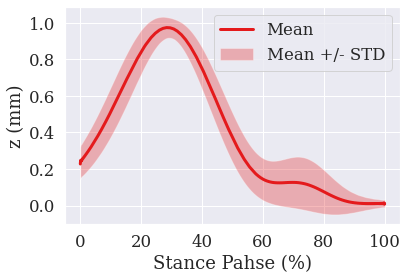

In [30]:
%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style("darkgrid", {'font.family': 'serif',
              'font.serif': 'Times New Roman'})

sns.set_palette("Set1")
sns.color_palette("Set1")

x = features['fal_z'].to_numpy().reshape(-1, N_SAMPLES)
t = np.linspace(0, 100, 1024)
x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)

# for i in range(x.shape[0]):
#     plt.plot(x[i, :], '--', alpha=0.2)
#     plt.xlabel("time")
#     plt.ylabel("z (mm)")

plt.plot(t, x_mean, linewidth=3, alpha=1, label="Mean")
plt.fill_between(
    t, x_mean + x_std,
    x_mean - x_std, alpha=0.3,
    label='Mean +/- STD'
)
plt.xlabel("Stance Pahse (%)")
plt.ylabel("z (mm)")
plt.legend(loc="upper right")
plt.show()


In [19]:
t.shape

(100,)